In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.optimize import minimize

#import numpy as np
import autograd.numpy as np
import autograd.numpy.random as npr
from autograd import grad
from autograd.util import flatten_func, flatten

## Generate data

In [2]:
def f1(x):
    return x**2/20 + np.sin(2*x)

((200, 1), (200, 1))

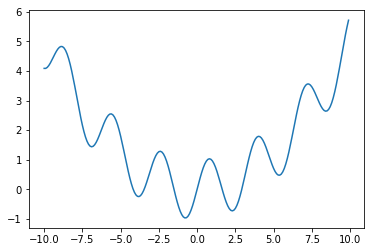

In [3]:
x = np.arange(-10, 10, 0.1).reshape(-1,1) # shape: [n_sample*n_in] (n_in=1 here)
y_true = f1(x)
plt.plot(x, y_true) 
x.shape, y_true.shape

## Build NN

https://github.com/HIPS/autograd/blob/master/examples/neural_net_regression.py

In [4]:
def init_weights(n_in=1, n_hidden=10, n_out=1):
    W1 = npr.randn(n_in, n_hidden)
    b1 = np.zeros(n_hidden)
    W2 = npr.randn(n_hidden, n_out)
    b2 = np.zeros(n_out)
    params = [W1, b1, W2, b2]
    return params

params = init_weights()
print([ p.shape for p in params ])

[(1, 10), (10,), (10, 1), (1,)]


In [5]:
def predict(params, x, act=np.tanh):
    W1, b1, W2, b2 = params
    
    a = act(np.dot(x, W1) + b1)
    y = np.dot(a, W2) + b2
    
    return y

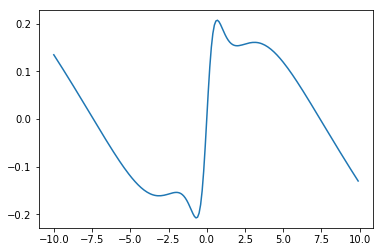

In [6]:
y_pred = predict(params, x)
plt.plot(x, y_pred)

In [7]:
def loss_func(params, x, y_true):
    y_pred = predict(params, x)
    loss = np.mean((y_pred - y_true)**2)
    return loss

In [8]:
loss_func(params, x, y_true)

5.4291211526426313

In [9]:
loss_grad_func = grad(loss_func)

In [10]:
loss_grad_func(params, x, y_true)

[array([[-0.00197857,  0.80850176, -0.2155142 , -0.00334588,  0.09453703,
         -0.0201857 , -0.39516054,  0.01420522, -0.05310073, -0.00290124]]),
 array([  2.14327107e-03,  -2.42251484e+00,   2.67289617e-01,
         -1.68882727e-04,  -1.67697166e-01,  -4.97689438e-03,
          1.18697007e+00,   1.22704510e-03,   5.62386471e-02,
         -2.04042210e-03]),
 array([[ 0.19661835],
        [-0.05318159],
        [-0.17768773],
        [ 0.16083495],
        [-0.15689567],
        [-0.19387406],
        [ 0.04933582],
        [-0.17777374],
        [ 0.18700583],
        [-0.19902996]]),
 array([-3.32302228])]

## Gradient descend

In [11]:
lr = 0.01 # learning rate

params = init_weights(n_hidden = 20) # re-initialize weight
for t in range(1000):
    loss_grad =  loss_grad_func(params, x, y_true)
    
    for p, p_grad in zip(params, loss_grad):
        p -= lr*p_grad
        
    if t % 50 == 0:
        loss = loss_func(params, x, y_true)
        print('{:.3f}'.format(loss))

5.247
2.728
2.078
1.845
1.576
1.365
1.180
1.059
0.959
0.868
0.785
0.726
0.684
0.651
0.625
0.604
0.879
0.710
0.660
0.634


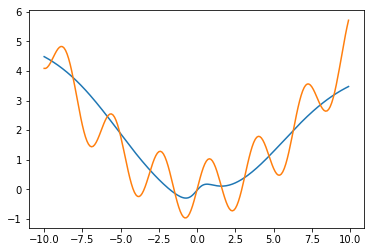

In [12]:
y_pred = predict(params, x)
plt.plot(x, y_pred)
plt.plot(x, y_true)

## Scipy optimization

Gradient function generated by autograd can be used the jacobian for scipy optimizers. Example:
- https://github.com/HIPS/autograd/blob/master/examples/rosenbrock.py

Scipy optimizer expects a single 1D array. Autograd provides functions to unroll a list of arrays to 1D array
- https://github.com/HIPS/autograd/blob/master/autograd/util.py#L87

### Flat weight parameters

In [13]:
params = init_weights(n_hidden = 10) # re-initialize weight

In [14]:
flattened_params, unflat_func = flatten(params)

In [15]:
def loss_wrap(flattened_params, x, y_true):
    params = unflat_func(flattened_params) # recover
    y_pred = predict(params, x)
    loss = np.mean((y_pred - y_true)**2)
    return loss

In [16]:
loss_func(params, x, y_true)

16.943307376555943

In [17]:
loss_wrap(flattened_params, x, y_true)

16.943307376555943

In [18]:
grad_wrap = grad(loss_wrap)

In [19]:
# use global x and y for now!
def loss_part(flattened_params):
    return loss_wrap(flattened_params, x, y_true)

def grad_part(flattened_params):
    # use global x and y for now
    return grad_wrap(flattened_params, x, y_true)

In [20]:
optim_params = minimize(loss_part, x0=flattened_params, jac=grad_part, method="BFGS")

In [21]:
o = optim_params
print(o.njev, o.nfev, o.message)

6763 6763 Maximum number of iterations has been exceeded.


In [22]:
loss_wrap(optim_params.x , x, y_true)

0.0026337937456121525

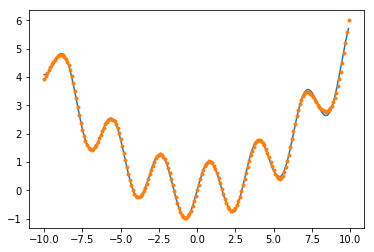

In [23]:
y_pred = predict(unflat_func(optim_params.x), x)
plt.plot(x, y_true)
plt.plot(x, y_pred, '.')